# 作業 : (Kaggle)鐵達尼生存預測

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 練習特徵重要性的寫作與觀察

# [作業重點]
- 仿造範例, 完成特徵重要性的計算, 並觀察對預測結果的影響 (In[3]~[5], Out[3]~[5]) 
- 仿造範例, 將兩個特徵重要性最高的特徵重組出新特徵, 並觀察對預測結果的影響 (In[8], Out[8]) 

In [8]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB


In [11]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    #Name、Sex、Ticket、Cabin、Embraked
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [12]:
df.values

array([[1.        , 0.12134831, 1.        , ..., 0.01415106, 0.        ,
        1.        ],
       [0.        , 0.21348315, 0.        , ..., 0.13913574, 0.55782313,
        0.33333333],
       [1.        , 0.39662921, 0.        , ..., 0.01546857, 0.        ,
        1.        ],
       ...,
       [1.        , 0.46404494, 0.        , ..., 0.04577135, 0.        ,
        1.        ],
       [0.        , 0.09101124, 1.        , ..., 0.0585561 , 0.41496599,
        0.33333333],
       [1.        , 0.24719101, 1.        , ..., 0.01512699, 0.        ,
        0.66666667]])

In [13]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Sex         0.230742
Ticket      0.164908
Fare        0.146158
Name        0.143344
Age         0.112820
Cabin       0.075310
Pclass      0.053448
SibSp       0.028134
Parch       0.028073
Embarked    0.017064
dtype: float64

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?


1.原始特徵 + 隨機森林：
  score=0.8205114074219081。
    
2.高重要性特徵 + 隨機森林：

  特徵刪除一半為 ['Sex', 'Ticket', 'Name', 'Fare', 'Age']，score =0.797913317566185。
    
採用高重要性特徵之後，正確率下降。

In [15]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8328144643549317

In [16]:
print("the index[:4]:",feats.index[:4])
print("the index[0:5]:",feats.index[:5])

the index[:4]: Index(['Sex', 'Ticket', 'Fare', 'Name'], dtype='object')
the index[0:5]: Index(['Sex', 'Ticket', 'Fare', 'Name', 'Age'], dtype='object')


In [17]:
# 高重要性特徵 + 隨機森林
"""
Your Code Here
"""
high_feature = feats.index[:5]

train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8081329547231759

In [18]:
high_feature

Index(['Sex', 'Ticket', 'Fare', 'Name', 'Age'], dtype='object')

In [ ]:
# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?

1.原始特徵 + 隨機森林： 

score=0.8205114074219081。

2.高重要性特徵 + 隨機森林：

特徵刪除一半為 ['Sex', 'Ticket', 'Name', 'Fare', 'Age']，

score =0.797913317566185。

3.新增特徵 df['Sex_Ticket'] = (df['Sex']/df['Sex'].max()+df['Ticket']/df['Ticket'].max())/2，

score=0.8126020866115065。

4.最高的兩個特徵(Sex,Ticker)+ 隨機森林，

Score=0.7554241862949223




In [19]:
# 觀察重要特徵與目標的分布
# 第一名   sex           
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=train_Y, y=df['Sex'], fit_reg=False)
plt.show()


sns.violinplot(x=train_Y, y=df['Sex'], fit_reg=False, scale="width")
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

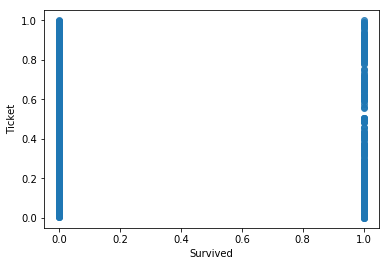

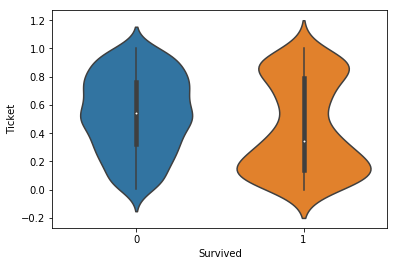

In [20]:
# 第二名  ticker 
sns.regplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()


sns.violinplot(x=train_Y, y=df['Ticket'], fit_reg=False)
plt.show()

In [21]:
df[['Sex','Ticket']]

,Sex,Ticket
0,1.0,0.769118
1,0.0,0.876471
2,0.0,0.983824
3,0.0,0.072059
4,1.0,0.694118
5,1.0,0.404412
6,1.0,0.125000
7,1.0,0.580882
8,0.0,0.505882
9,0.0,0.194118


In [25]:
# 製作新特徵看效果
"""
Your Code Here
"""
df['Sex_Ticket'] = (df['Sex']/df['Sex'].max()+df['Ticket']/df['Ticket'].max())/2


train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8126020866115065

In [26]:
high_feature = feats.index[:2]

train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7554241862949223

In [27]:
high_feature

Index(['Sex', 'Ticket'], dtype='object')